/usr/local/lib/python3.12/dist-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


Sample rate: 0.0016802751450550027


/tmp/ipython-input-3609985916.py:135: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.
  loss.backward()


Epoch 01 - Loss: 0.2025 - eps: 0.11
Epoch 02 - Loss: 0.1523 - eps: 0.15
Epoch 03 - Loss: 0.1181 - eps: 0.19
Epoch 04 - Loss: 0.0977 - eps: 0.22
Epoch 05 - Loss: 0.0756 - eps: 0.24
Epoch 06 - Loss: 0.0667 - eps: 0.27
Epoch 07 - Loss: 0.0628 - eps: 0.29
Epoch 08 - Loss: 0.0595 - eps: 0.31
Epoch 09 - Loss: 0.0544 - eps: 0.33
Epoch 10 - Loss: 0.0518 - eps: 0.35
Synthetic data saved to disk.

===== Summary for TimeSeconds =====
Real mean:    1718462125.6012826
Synthetic mean: 1719640800.0
Real median:    1718467899.5
Synthetic median: 1719686144.0
Real std:       2265577.7162217502
Synthetic std:  713739.5625
Real min:       1714521637
Synthetic min:  1718462208.0
Real max:       1722383984
Synthetic max:  1720727552.0
Real IQR:       3915523.25
Synthetic IQR:  1294208.0


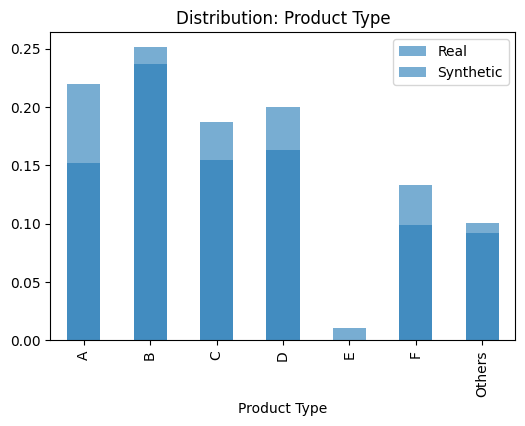

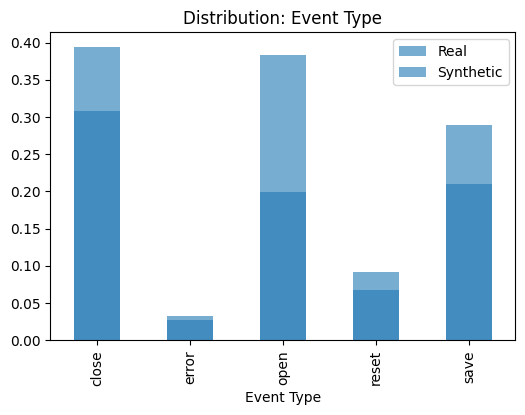

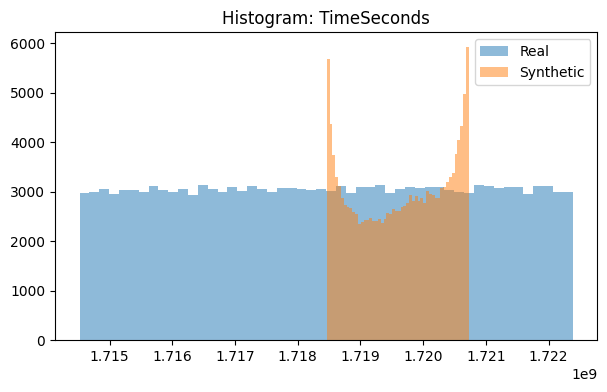


Nearest neighbor distances (first 10):
[[1.05746815e-05]
 [1.50377736e-05]
 [8.60518242e-05]
 [1.01951798e-04]
 [1.12115543e-04]
 [1.31069082e-04]
 [1.43452180e-04]
 [4.88111386e-04]
 [5.41177874e-04]
 [9.91351880e-04]]
Minimum distance: 2.3533674791895165e-11
Median distance: 0.00018183230264401384


In [5]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from opacus import PrivacyEngine

import matplotlib.pyplot as plt
import seaborn as sns

# =========================================
# 1. LOAD DATA
# =========================================

df_raw = pd.read_csv("synthetic_telemetry_data.csv")

# Keep original time string for later human friendly output
df = df_raw.copy()
df = df.drop(columns=["User ID"], errors="ignore")

# Create a numeric timestamp column for modeling
df["TimeSeconds"] = pd.to_datetime(df["Time of Event"]).astype("int64") // 1_000_000_000

categorical_cols = ["Product Type", "Event Type"]
numeric_cols = ["TimeSeconds"]

# =========================================
# 2. FIT COLUMN TRANSFORMER ON REAL DATA
# =========================================

transformer = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(sparse_output=False), categorical_cols),
        ("num", StandardScaler(), numeric_cols),
    ]
)

# Fit on real data and keep the transformed matrix
X_real = transformer.fit_transform(df[categorical_cols + numeric_cols])

# =========================================
# 3. DATASET AND DATALOADER
# =========================================

class TelemetryDataset(Dataset):
    def __init__(self, X):
        self.X = torch.tensor(X, dtype=torch.float32)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx]

dataset = TelemetryDataset(X_real)

batch_size = 256
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

input_dim = X_real.shape[1]
latent_dim = 16

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =========================================
# 4. AUTOENCODER MODEL
# =========================================

class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim),
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim),
            nn.Sigmoid(),   # OK because inputs are scaled and one hot
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

model = Autoencoder(input_dim, latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss(reduction="mean")

# =========================================
# 5. MAKE TRAINING DP WITH OPACUS
# =========================================

privacy_engine = PrivacyEngine()

# sample_rate = batch_size / total_points is what DP uses
sample_rate = batch_size / len(dataset)

model, optimizer, dataloader = privacy_engine.make_private(
    module=model,
    optimizer=optimizer,
    data_loader=dataloader,
    noise_multiplier=1.5,    # tune this
    max_grad_norm=1.0,
)

print("Sample rate:", sample_rate)

# =========================================
# 6. TRAINING LOOP WITH DP SGD
# =========================================

epochs = 10

for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0

    for batch in dataloader:
        batch = batch.to(device)

        optimizer.zero_grad()
        recon = model(batch)
        loss = criterion(recon, batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * batch.size(0)

    epoch_loss /= len(dataset)
    eps = privacy_engine.accountant.get_epsilon(delta=1e-5)
    print(f"Epoch {epoch+1:02d} - Loss: {epoch_loss:.4f} - eps: {eps:.2f}")

# =========================================
# 7. GENERATE SYNTHETIC DATA
# =========================================

model.eval()
num_samples = len(df)

with torch.no_grad():
    # You can also sample z from encoder outputs of real data
    # For now, use standard normal
    z = torch.randn(num_samples, latent_dim, device=device)
    synthetic_matrix = model.decoder(z).cpu().numpy()

# =========================================
# 8. DECODE BACK TO ORIGINAL FEATURES
# =========================================

# 8a. Decode categorical from one hot
cat_encoder = transformer.named_transformers_["cat"]
cat_sizes = [len(c) for c in cat_encoder.categories_]

cat_end = sum(cat_sizes)
cat_mat = synthetic_matrix[:, :cat_end]

start = 0
decoded_cats = []

for i, size in enumerate(cat_sizes):
    block = cat_mat[:, start:start + size]
    labels = cat_encoder.categories_[i]
    max_idx = block.argmax(axis=1)
    decoded_cats.append(pd.Series(labels[max_idx], name=categorical_cols[i]))
    start += size

cat_df = pd.concat(decoded_cats, axis=1)

# 8b. Decode numeric columns (still numeric seconds here)
num_mat = synthetic_matrix[:, cat_end:]
num_scaler = transformer.named_transformers_["num"]
num_real = num_scaler.inverse_transform(num_mat)

num_df = pd.DataFrame(num_real, columns=numeric_cols)

# Clip to real range to avoid crazy outliers
real_min = df["TimeSeconds"].min()
real_max = df["TimeSeconds"].max()
num_df["TimeSeconds"] = num_df["TimeSeconds"].clip(real_min, real_max)

# Create a human readable time column
num_df["Time of Event"] = pd.to_datetime(num_df["TimeSeconds"], unit="s")

synthetic_df = pd.concat([cat_df, num_df], axis=1)

synthetic_df.to_csv("synthetic_private_telemetry_data.csv", index=False)
print("Synthetic data saved to disk.")

# =========================================
# 9. SIMPLE QUERY STYLE COMPARISONS
# =========================================

# For comparisons, keep using the numeric TimeSeconds,
# not the datetime, so types match.

def summarize_column(real, syn, col):
    print(f"\n===== Summary for {col} =====")
    print("Real mean:   ", real[col].mean())
    print("Synthetic mean:", syn[col].mean())
    print("Real median:   ", real[col].median())
    print("Synthetic median:", syn[col].median())
    print("Real std:      ", real[col].std())
    print("Synthetic std: ", syn[col].std())
    print("Real min:      ", real[col].min())
    print("Synthetic min: ", syn[col].min())
    print("Real max:      ", real[col].max())
    print("Synthetic max: ", syn[col].max())
    print("Real IQR:      ", real[col].quantile(0.75) - real[col].quantile(0.25))
    print("Synthetic IQR: ", syn[col].quantile(0.75) - syn[col].quantile(0.25))

for col in numeric_cols:
    summarize_column(df, synthetic_df, col)

# Category distribution queries
def compare_categorical(real_df, syn_df, col):
    plt.figure(figsize=(6, 4))
    real_df[col].value_counts(normalize=True).sort_index().plot(kind="bar", alpha=0.6, label="Real")
    syn_df[col].value_counts(normalize=True).sort_index().plot(kind="bar", alpha=0.6, label="Synthetic")
    plt.title("Distribution: " + col)
    plt.legend()
    plt.show()

for col in categorical_cols:
    compare_categorical(df, synthetic_df, col)

# Numeric distribution plots (no datetime here, so no error)
def compare_numeric(real_df, syn_df, col):
    plt.figure(figsize=(7, 4))
    plt.hist(real_df[col], bins=50, alpha=0.5, label="Real")
    plt.hist(syn_df[col], bins=50, alpha=0.5, label="Synthetic")
    plt.title("Histogram: " + col)
    plt.legend()
    plt.show()

for col in numeric_cols:
    compare_numeric(df, synthetic_df, col)

# =========================================
# 10. NEAREST NEIGHBOR PRIVACY TEST
# =========================================

from sklearn.neighbors import NearestNeighbors

# Use the same feature space for both
real_mat = X_real
syn_mat = transformer.transform(synthetic_df[categorical_cols + numeric_cols])

nbrs = NearestNeighbors(n_neighbors=1).fit(real_mat)
distances, _ = nbrs.kneighbors(syn_mat)

print("\nNearest neighbor distances (first 10):")
print(np.sort(distances[:10], axis=0))
print("Minimum distance:", np.min(distances))
print("Median distance:", np.median(distances))


In [6]:
# =========================================
# 11. QUERY ENGINE
# =========================================

def query_mean(df, col):
    return df[col].mean()

def query_max(df, col):
    return df[col].max()

def query_min(df, col):
    return df[col].min()

def query_count(df, col, value):
    """How many times does a value appear in a column?"""
    return (df[col] == value).sum()

def query_value_counts(df, col):
    """Category distribution"""
    return df[col].value_counts()

def query_group_mean(df, group_col, value_col):
    """Mean of numeric column grouped by category"""
    return df.groupby(group_col)[value_col].mean()

def query_top_category(df, col):
    """Most common category"""
    return df[col].value_counts().idxmax()


In [18]:
# Mean time
query_mean(df, "TimeSeconds")

np.float64(1718462125.6012826)

In [19]:
query_mean(synthetic_df, "TimeSeconds")

np.float32(1719640800.0)

In [17]:
# Maximum time
query_max(df, "TimeSeconds")

1722383984

In [16]:
query_max(synthetic_df, "TimeSeconds")

1720727552.0

In [20]:
# Count
query_count(df, "Product Type", "Premium")

np.int64(0)

In [14]:
query_count(synthetic_df, "Product Type", "Premium")

np.int64(0)

In [23]:
# Category Distribution
query_value_counts(df, "Product Type")

,count
Product Type,
B,38325
D,30531
C,28470
A,23096
Others,15289
F,15064
E,1581


In [24]:
query_value_counts(synthetic_df, "Product Type")

,count
Product Type,
B,36062
A,33491
D,24900
C,23601
F,20246
Others,14048
E,8


In [29]:
# most common product type
query_top_category(df, "Product Type")

'B'

In [27]:
query_top_category(synthetic_df, "Product Type")

'B'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
